<a href="https://colab.research.google.com/github/shivakalyanrojed/Demo/blob/main/Thyroid%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
!pip install keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
data = pd.read_csv(r'/content/sample_data/thyroidDF.csv')
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [5]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [6]:
data.isnull().sum()

,0
age,0
sex,307
on_thyroxine,0
query_on_thyroxine,0
on_antithyroid_meds,0
sick,0
pregnant,0
thyroid_surgery,0
I131_treatment,0
query_hypothyroid,0


In [7]:
data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source', 'patient_id'], axis=1, inplace=True)


In [8]:
# Remapping target values to diagnostic group
diagnoses = {
    'A': 'hyperthyroid conditions', 'B': 'hyperthyroid conditions',
    'C': 'hyperthyroid conditions', 'D': 'hyperthyroid conditions',
    'E': 'hypothyroid conditions', 'F': 'hypothyroid conditions',
    'G': 'hypothyroid conditions', 'H': 'hypothyroid conditions',
    'I': 'binding protein', 'J': 'binding protein',
    'K': 'general health', 'L': 'replacement therapy',
    'M': 'replacement therapy', 'N': 'replacement therapy',
    'O': 'antithyroid treatment', 'P': 'antithyroid treatment',
    'Q': 'antithyroid treatment', 'R': 'miscellaneous',
    'S': 'miscellaneous', 'T': 'miscellaneous'
}

In [9]:
data['target'] = data['target'].map(diagnoses)
data.dropna(subset=['target'], inplace=True)
print(data['target'].value_counts())

target
hypothyroid conditions     593
general health             436
binding protein            376
replacement therapy        336
miscellaneous              281
hyperthyroid conditions    182
antithyroid treatment       33
Name: count, dtype: int64


In [10]:
print(data[data.age > 100])

Empty DataFrame
Columns: [age, sex, on_thyroxine, query_on_thyroxine, on_antithyroid_meds, sick, pregnant, thyroid_surgery, I131_treatment, query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, hypopituitary, psych, TSH, T3, TT4, T4U, FTI, TBG, target]
Index: []

[0 rows x 23 columns]


In [11]:
# Split the data
x = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [12]:
x

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG
4,32,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,NaN,NaN,NaN,36.0
18,63,F,t,f,f,t,f,f,f,f,...,f,f,f,f,68.000000,NaN,48.0,1.02,47.0,NaN
32,41,M,f,f,f,f,f,f,f,f,...,f,f,f,f,0.050000,1.6,39.0,1.00,39.0,NaN
33,71,F,t,f,f,f,f,f,f,f,...,f,f,f,f,0.050000,NaN,126.0,1.38,91.0,NaN
39,55,F,t,f,f,f,f,f,f,t,...,f,f,f,f,9.599999,2.4,136.0,1.48,92.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153,64,M,f,f,f,f,f,f,f,f,...,f,f,f,f,0.810000,NaN,31.0,0.55,56.0,NaN
9157,60,M,f,f,t,f,f,f,f,f,...,f,f,f,f,0.180000,NaN,28.0,0.87,32.0,NaN
9158,64,M,f,f,f,f,f,f,f,t,...,f,f,f,f,NaN,NaN,44.0,0.53,83.0,NaN
9162,36,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,84.0,1.26,67.0,NaN


In [13]:
y

,target
4,miscellaneous
18,hypothyroid conditions
32,miscellaneous
33,binding protein
39,replacement therapy
...,...
9153,general health
9157,general health
9158,binding protein
9162,binding protein


In [14]:
x['sex'].unique()

array(['F', 'M', nan], dtype=object)

In [15]:
x['sex'].value_counts()

,count
sex,
F,1611
M,536


In [16]:
# Converting the data
x['age'] = x['age'].astype('float')
x['TSH'] = x['TSH'].astype('float')
x['T3'] = x['T3'].astype('float')
x['TT4'] = x['TT4'].astype('float')
x['T4U'] = x['T4U'].astype('float')
x['FTI'] = x['FTI'].astype('float')
x['TBG'] = x['TBG'].astype('float')

In [17]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2237 entries, 4 to 9169
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  2237 non-null   float64
 1   sex                  2147 non-null   object 
 2   on_thyroxine         2237 non-null   object 
 3   query_on_thyroxine   2237 non-null   object 
 4   on_antithyroid_meds  2237 non-null   object 
 5   sick                 2237 non-null   object 
 6   pregnant             2237 non-null   object 
 7   thyroid_surgery      2237 non-null   object 
 8   I131_treatment       2237 non-null   object 
 9   query_hypothyroid    2237 non-null   object 
 10  query_hyperthyroid   2237 non-null   object 
 11  lithium              2237 non-null   object 
 12  goitre               2237 non-null   object 
 13  tumor                2237 non-null   object 
 14  hypopituitary        2237 non-null   object 
 15  psych                2237 non-null   object

In [18]:
# Ordinal encoding for categorical features
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Impute missing values with a placeholder before encoding
# You can choose a suitable placeholder value like 'missing' or -1
for column in x.columns[1:16]:
    x[column] = x[column].fillna('missing')

# Now apply OrdinalEncoder
ordinal_encoder = OrdinalEncoder(dtype='int64', handle_unknown='use_encoded_value', unknown_value=-1) # Handle unknown values during transform
x[x.columns[1:16]] = ordinal_encoder.fit_transform(x.iloc[:, 1:16])

# Optional: If you want to replace the placeholder with a specific value after encoding
#x[x.columns[1:16]] = x[x.columns[1:16]].replace(-1, 0) # Example: Replace -1 with 0

In [19]:
# Ordinal encoding for categorical features
ordinal_encoder = OrdinalEncoder(dtype='int64')
x[x.columns[1:16]] = ordinal_encoder.fit_transform(x.iloc[:, 1:16])
x.fillna(0, inplace=True)

In [20]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [21]:
# Scale the data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [22]:
# Handling imbalanced data
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0, k_neighbors=1)
x_bal, y_bal = os.fit_resample(x_train, y_train)
x_test_bal, y_test_bal = os.fit_resample(x_test, y_test)

In [24]:
print(y_train.value_counts())
print(x_bal)

target
hypothyroid conditions     471
general health             351
binding protein            302
replacement therapy        265
miscellaneous              230
hyperthyroid conditions    144
antithyroid treatment       26
Name: count, dtype: int64
[[-1.69065366 -0.58503281 -0.45692864 ... -2.42054833 -1.49123375
   3.36064931]
 [-0.21146714 -0.58503281  2.18852553 ... -0.26780448  0.16088479
  -0.18244657]
 [ 1.06369366  1.2872815  -0.45692864 ...  0.14718228 -0.13703823
  -0.18244657]
 ...
 [ 1.26771939 -0.58503281  2.18852553 ...  0.40739602  0.14468939
  -0.18244657]
 [ 0.68966814  1.2872815   2.18852553 ...  0.07800682  1.07170411
  -0.18244657]
 [ 1.05362086 -0.58503281  2.18852553 ...  0.47907369 -0.2779769
  -0.18244657]]


In [25]:
# Convert arrays to dataframes
columns = ['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
x_train_bal = pd.DataFrame(x_bal, columns=columns)
y_train_bal = pd.DataFrame(y_bal, columns=['target'])
x_test_bal = pd.DataFrame(x_test_bal, columns=columns)
y_test_bal = pd.DataFrame(y_test_bal, columns=['target'])

In [26]:
# Random Forest Classifier Model
rfr = RandomForestClassifier().fit(x_bal, y_bal.values.ravel())
y_pred = rfr.predict(x_test_bal)
print(classification_report(y_test_bal, y_pred))


                         precision    recall  f1-score   support

  antithyroid treatment       0.98      0.98      0.98       122
        binding protein       0.84      0.89      0.86       122
         general health       0.93      0.98      0.95       122
hyperthyroid conditions       0.93      0.85      0.89       122
 hypothyroid conditions       0.97      1.00      0.98       122
          miscellaneous       0.95      0.97      0.96       122
    replacement therapy       1.00      0.93      0.97       122

               accuracy                           0.94       854
              macro avg       0.94      0.94      0.94       854
           weighted avg       0.94      0.94      0.94       854



In [27]:
print(x_bal.shape, y_bal.shape, x_test_bal.shape, y_test_bal.shape)

(3297, 22) (3297,) (854, 22) (854, 1)


In [28]:
from sklearn.metrics import accuracy_score
test_score=accuracy_score(y_test_bal,y_pred)

In [29]:
test_score

0.9414519906323185

In [30]:
train_score = accuracy_score(y_bal,rfr.predict(x_bal))
train_score

1.0

In [31]:
# Feature importance
from sklearn.inspection import permutation_importance
results = permutation_importance(rfr, x_bal, y_bal, scoring='accuracy')
feature_importance = ['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
importance = results.importances_mean
importance = np.sort(importance)
for i, v in enumerate(importance):
    i = feature_importance[i]
    print('Feature: {:<20} Score: {}'.format(i, v))

Feature: age                  Score: 0.0
Feature: sex                  Score: 0.0
Feature: on_thyroxine         Score: 0.0
Feature: query_on_thyroxine   Score: 0.0
Feature: on_antithyroid_meds  Score: 6.066120715801926e-05
Feature: sick                 Score: 0.00024264482863207705
Feature: pregnant             Score: 0.0003033060357900963
Feature: thyroid_surgery      Score: 0.0009099181073702889
Feature: I131_treatment       Score: 0.0011525629360024548
Feature: query_hypothyroid    Score: 0.0014558689717925732
Feature: query_hyperthyroid   Score: 0.0017591750075826695
Feature: lithium              Score: 0.0022444646648468237
Feature: goitre               Score: 0.0024264482863208814
Feature: tumor                Score: 0.01856232939035487
Feature: hypopituitary        Score: 0.027418865635426126
Feature: psych                Score: 0.029178040643008794
Feature: TSH                  Score: 0.058659387321807734
Feature: T3                   Score: 0.07000303306035793
Feature: TT4    

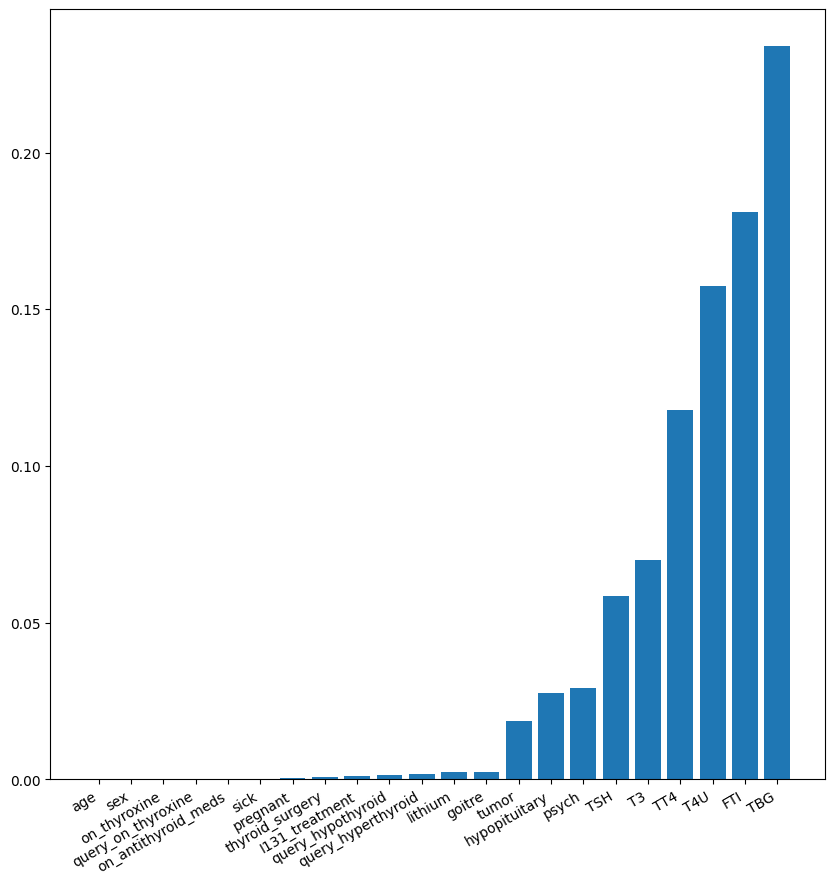

In [32]:
plt.figure(figsize=(10, 10))
plt.bar(feature_importance, importance.astype(float))
plt.xticks(rotation=30, ha='right')
plt.show()

In [33]:
x.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG
4,32.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0.0,0.0,0.00,0.0,36.0
18,63.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,68.000000,0.0,48.0,1.02,47.0,0.0
32,41.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.050000,1.6,39.0,1.00,39.0,0.0
33,71.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0.050000,0.0,126.0,1.38,91.0,0.0
39,55.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,9.599999,2.4,136.0,1.48,92.0,0.0


In [34]:
# Convert x_bal back to a DataFrame if necessary
if isinstance(x_bal, np.ndarray):
    x_bal = pd.DataFrame(x_bal, columns=columns)  # Assuming 'columns' contains the column names

# Now you can drop the columns
x_bal.drop(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment'], axis=1, inplace=True)

# Drop the specified columns from the dataframe (assuming x_test_bal is still a DataFrame)
x_test_bal.drop(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment'], axis=1, inplace=True)

# Print the first 5 rows of the dataframe
x_bal.head()

,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG
0,-0.310163,-0.310163,-0.082176,-0.071107,-0.17642,-0.033454,-0.147316,-0.316629,-0.939410,-1.772193,-2.420548,-1.491234,3.360649
1,-0.310163,-0.310163,-0.082176,-0.071107,-0.17642,-0.033454,-0.147316,-0.138016,0.311883,-0.160764,-0.267804,0.160885,-0.182447
2,-0.310163,-0.310163,-0.082176,-0.071107,-0.17642,-0.033454,-0.147316,-0.287665,-0.346692,-0.192674,0.147182,-0.137038,-0.182447
3,-0.310163,-0.310163,-0.082176,-0.071107,5.66830,-0.033454,-0.147316,-0.292492,1.168030,0.094511,0.458422,-0.069328,-0.182447
4,-0.310163,3.224113,-0.082176,-0.071107,-0.17642,-0.033454,-0.147316,-0.309388,4.921907,1.610212,-0.138121,1.758835,-0.182447


In [35]:
x_bal_filtered = x_bal[['goitre', 'tumor' , 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']]
x_test_bal_filtered = x_test_bal[['goitre', 'tumor' , 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']]

In [36]:
x_bal_filtered.head()

,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG
0,-0.071107,-0.17642,-0.033454,-0.147316,-0.316629,-0.939410,-1.772193,-2.420548,-1.491234,3.360649
1,-0.071107,-0.17642,-0.033454,-0.147316,-0.138016,0.311883,-0.160764,-0.267804,0.160885,-0.182447
2,-0.071107,-0.17642,-0.033454,-0.147316,-0.287665,-0.346692,-0.192674,0.147182,-0.137038,-0.182447
3,-0.071107,5.66830,-0.033454,-0.147316,-0.292492,1.168030,0.094511,0.458422,-0.069328,-0.182447
4,-0.071107,-0.17642,-0.033454,-0.147316,-0.309388,4.921907,1.610212,-0.138121,1.758835,-0.182447


In [37]:
from sklearn.ensemble import RandomForestClassifier

RFclassifier = RandomForestClassifier(max_leaf_nodes=30)
RFclassifier.fit(x_train, y_train)

RandomForestClassifier(max_leaf_nodes=30)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix # Import confusion_matrix

RFclassifier = RandomForestClassifier(max_leaf_nodes=30)
RFclassifier.fit(x_train, y_train)

y_pred = RFclassifier.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) # Now you can use confusion_matrix

                         precision    recall  f1-score   support

  antithyroid treatment       1.00      0.14      0.25         7
        binding protein       0.85      0.86      0.86        74
         general health       0.89      1.00      0.94        85
hyperthyroid conditions       0.82      0.82      0.82        38
 hypothyroid conditions       0.95      1.00      0.97       122
          miscellaneous       0.95      0.80      0.87        51
    replacement therapy       0.99      0.93      0.96        71

               accuracy                           0.92       448
              macro avg       0.92      0.79      0.81       448
           weighted avg       0.92      0.92      0.91       448

[[  1   0   0   0   6   0   0]
 [  0  64   6   4   0   0   0]
 [  0   0  85   0   0   0   0]
 [  0   5   0  31   0   1   1]
 [  0   0   0   0 122   0   0]
 [  0   4   2   3   1  41   0]
 [  0   2   2   0   0   1  66]]


In [39]:
# HyperParameter Tuning for RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf, cv=5)
grid_rf.fit(x_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 300}


In [40]:
from sklearn.model_selection import GridSearchCV
rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None]
}
RFclassifier = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(RFclassifier, rf, cv=5)
grid_rf.fit(x_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)
y_pred = grid_rf.predict(x_test)
print(classification_report(y_test,y_pred))

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 300}
                         precision    recall  f1-score   support

  antithyroid treatment       1.00      0.43      0.60         7
        binding protein       0.89      0.95      0.92        74
         general health       0.95      0.99      0.97        85
hyperthyroid conditions       0.86      0.84      0.85        38
 hypothyroid conditions       0.97      1.00      0.98       122
          miscellaneous       0.94      0.90      0.92        51
    replacement therapy       1.00      0.93      0.96        71

               accuracy                           0.94       448
              macro avg       0.94      0.86      0.89       448
           weighted avg       0.95      0.94      0.94       448



In [43]:
print(confusion_matrix(y_test, y_pred))

[[  3   0   0   0   4   0   0]
 [  0  70   1   3   0   0   0]
 [  0   1  84   0   0   0   0]
 [  0   4   0  32   0   2   0]
 [  0   0   0   0 122   0   0]
 [  0   2   1   2   0  46   0]
 [  0   2   2   0   0   1  66]]


In [44]:
RFAcc = accuracy_score(y_pred,y_test)
print('Random Forest accuracy is: {:.2f}%'.format(RFAcc*100))

Random Forest accuracy is: 94.42%


In [94]:
!pip install scikit-learn==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.0 which is incompatible.


In [45]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
xgb = XGBClassifier()
xgb.fit(x_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:
y_test_encoded = le.transform(y_test)
y_pred = xgb.predict(x_test)
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.91      0.95      0.93        74
           2       0.95      0.96      0.96        85
           3       0.86      0.84      0.85        38
           4       1.00      1.00      1.00       122
           5       0.92      0.90      0.91        51
           6       0.99      0.96      0.97        71

    accuracy                           0.95       448
   macro avg       0.95      0.94      0.95       448
weighted avg       0.95      0.95      0.95       448



In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 150, 200],
}
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train_encoded)
best_params = grid_search.best_params_
print("Best parameters:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.9620535714285714


In [48]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(x_train, y_train_encoded)
print("Best parameters for XGBClassifier:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test_encoded, y_pred))

Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.92      0.95      0.93        74
           2       0.95      0.99      0.97        85
           3       0.87      0.87      0.87        38
           4       0.99      1.00      1.00       122
           5       0.92      0.90      0.91        51
           6       1.00      0.94      0.97        71

    accuracy                           0.96       448
   macro avg       0.95      0.93      0.94       448
weighted avg       0.96      0.96      0.96       448



In [49]:
print(confusion_matrix(y_test_encoded, y_pred))

[[  6   0   0   0   1   0   0]
 [  0  70   1   3   0   0   0]
 [  0   0  84   0   0   1   0]
 [  0   3   0  33   0   2   0]
 [  0   0   0   0 122   0   0]
 [  0   2   1   2   0  46   0]
 [  0   1   2   0   0   1  67]]


In [50]:
XGBAcc = accuracy_score(y_test_encoded, y_pred)
print('XGB accuracy is: {:.2f}%'.format(XGBAcc*100))

XGB accuracy is: 95.54%


In [51]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel='linear', max_iter=251)
SVCclassifier.fit(x_train, y_train)

SVC(kernel='linear', max_iter=251)

In [52]:
# Hyperparametric Tuning for SVC model
svc_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(SVC(), svc_params, cv=5)
grid_svc.fit(x_train, y_train)

print("Best parameters for SVC:", grid_svc.best_params_)

Best parameters for SVC: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


In [53]:
y_pred = SVCclassifier.predict(x_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

  antithyroid treatment       0.55      0.86      0.67         7
        binding protein       0.81      0.70      0.75        74
         general health       0.73      0.87      0.79        85
hyperthyroid conditions       0.74      0.61      0.67        38
 hypothyroid conditions       0.92      0.93      0.93       122
          miscellaneous       0.67      0.51      0.58        51
    replacement therapy       0.88      0.96      0.92        71

               accuracy                           0.81       448
              macro avg       0.76      0.78      0.76       448
           weighted avg       0.81      0.81      0.81       448



In [54]:
print(confusion_matrix(y_test, y_pred))

[[  6   0   0   0   1   0   0]
 [  2  52   7   3   3   7   0]
 [  1   1  74   0   2   2   5]
 [  0   5   4  23   1   4   1]
 [  1   2   2   0 114   0   3]
 [  1   3  14   4   3  26   0]
 [  0   1   1   1   0   0  68]]


In [55]:
#Evaluating Performance Of The svc Model Using GridSearch CV

from sklearn.model_selection import GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.8660714285714286


In [56]:
SVCAcc = accuracy_score(y_pred,y_test)
print('SVC accuracy is: {:.2f}%'.format(SVCAcc*100))

SVC accuracy is: 86.61%


In [57]:
models = pd.DataFrame({
    'Model' : ['Random Forest Classifier','SVC Model','XGB classifier'],
    'Score' : [RFAcc,SVCAcc,XGBAcc]
    })
models.sort_values(by = 'Score', ascending = False)

,Model,Score
2,XGB classifier,0.955357
0,Random Forest Classifier,0.944196
1,SVC Model,0.866071


In [58]:
import pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [59]:
pickle.dump(RFclassifier,open('thyroid_1_model.pkl','wb'))